# Bootstrapping using `xskillscore.resample_iterations` or `xskillscore.resample_iterations_idx`

Bootstrapping is in my view a relatively safe way to compute confidence intervals (works for non-normal data, etc.). However, it can be expensive to run, making an efficient implementation crucial.

I came across [`xskillscore.resample_iterations`](https://xskillscore.readthedocs.io/en/stable/api/xskillscore.core.resampling.resample_iterations.html?highlight=resample_iterations#xskillscore.core.resampling.resample_iterations) / [`xskillscore.resample_iterations_idx`](https://xskillscore.readthedocs.io/en/stable/api/xskillscore.core.resampling.resample_iterations_idx.html), which I find neat. It might be overkill to install the entire package, when only using this single function (that can be used standalone), so one could think about just copying the code (bearing in mind potantial copy rights).

Here is a little example of how to use it for computing the confidence interval of the air temperature diurnal cycle at every grid point.

In [1]:
!python --version

Python 3.12.9


In [2]:
import xarray as xr
import numpy as np
import ultraplot as uplt

import xskillscore
from xskillscore import resample_iterations, resample_iterations_idx

for pkg in [uplt, xr, np, xskillscore]:
    print(f"{pkg.__name__}: {pkg.__version__}")

ultraplot: 1.57.2
xarray: 2025.7.1
numpy: 2.3.1
xskillscore: 0.0.26


In [3]:
ds = xr.tutorial.open_dataset("air_temperature").compute()
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [4]:
# diurnal cycle for january

MONTH = 1.0  # 1 for January
ds_jan = ds.sel(time=ds.time.dt.month == MONTH)


grouped = ds_jan.groupby("time.hour")
grouped

<DatasetGroupBy, grouped over 1 grouper(s), 4 groups in total:
    'hour': UniqueGrouper('hour'), 4/4 groups with labels 0, 6, 12, 18>

In [5]:
def bootstrapped_ci_of_mean(
    group,
    n_iterations=1000,
    alpha=0.05,
    dim="time",
    use_idx_function_for_resampling=False,
    verbose=False,
    *args,
    **kwargs,
):
    # first timestep to indicate the hour of the group
    time = group.time.dt.hour[0].values.item()

    if verbose:
        print(f"Resampling group (time = {time}) with {n_iterations} iterations.")

    # resample_iterations_idx is faster, but I had the impression that it can fail when using dask
    resample = (
        resample_iterations_idx
        if use_idx_function_for_resampling
        else resample_iterations
    )

    # the actual resampling
    group_resampled = resample(group, iterations=n_iterations, dim=dim)

    # calculate the mean (e.g., over time) and confidence intervals (over iteration)
    group_resampled_mean = group_resampled.mean(dim=dim)
    group_resampled_ci = group_resampled_mean.quantile(
        [alpha / 2, 1 - alpha / 2], dim="iteration"
    )
    return group_resampled_ci


grouped_ci_of_mean = grouped.apply(
    bootstrapped_ci_of_mean,
    n_iterations=1000,
    alpha=0.05,
    dim="time",
    use_idx_function_for_resampling=False,
    verbose=True,
)
grouped_ci_of_mean

Resampling group (time = 0) with 1000 iterations.
Resampling group (time = 6) with 1000 iterations.
Resampling group (time = 12) with 1000 iterations.
Resampling group (time = 18) with 1000 iterations.


<xarray.Dataset> Size: 85kB
Dimensions:   (hour: 4, quantile: 2, lat: 25, lon: 53)
Coordinates:
  * lat       (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon       (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * quantile  (quantile) float64 16B 0.025 0.975
  * hour      (hour) int64 32B 0 6 12 18
Data variables:
    air       (hour, quantile, lat, lon) float64 85kB 245.0 245.1 ... 296.2

In [6]:
%%time

# with use_idx_function_for_resampling=False: resample_iterations
# this is slower, but works better for larger arrays, and I had the impressions it is less proun to errors when using dask 

grouped.apply(
    bootstrapped_ci_of_mean, n_iterations=1000, alpha=0.05, dim="time", use_idx_function_for_resampling=False
)

CPU times: user 5.56 s, sys: 2.38 s, total: 7.95 s
Wall time: 7.98 s


<xarray.Dataset> Size: 85kB
Dimensions:   (hour: 4, quantile: 2, lat: 25, lon: 53)
Coordinates:
  * lat       (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon       (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * quantile  (quantile) float64 16B 0.025 0.975
  * hour      (hour) int64 32B 0 6 12 18
Data variables:
    air       (hour, quantile, lat, lon) float64 85kB 245.1 245.2 ... 296.2

In [7]:
%%time

# with use_idx_function_for_resampling=True: resample_iterations_idx
# this is faster, but I had the impressions that it can fail when when using dask

grouped.apply(
    bootstrapped_ci_of_mean, n_iterations=1000, alpha=0.05, dim="time", use_idx_function_for_resampling=True
)


CPU times: user 1.33 s, sys: 1.63 s, total: 2.96 s
Wall time: 2.97 s


<xarray.Dataset> Size: 85kB
Dimensions:   (hour: 4, quantile: 2, lat: 25, lon: 53)
Coordinates:
  * lat       (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon       (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * quantile  (quantile) float64 16B 0.025 0.975
  * hour      (hour) int64 32B 0 6 12 18
Data variables:
    air       (hour, quantile, lat, lon) float64 85kB 245.2 245.2 ... 296.2

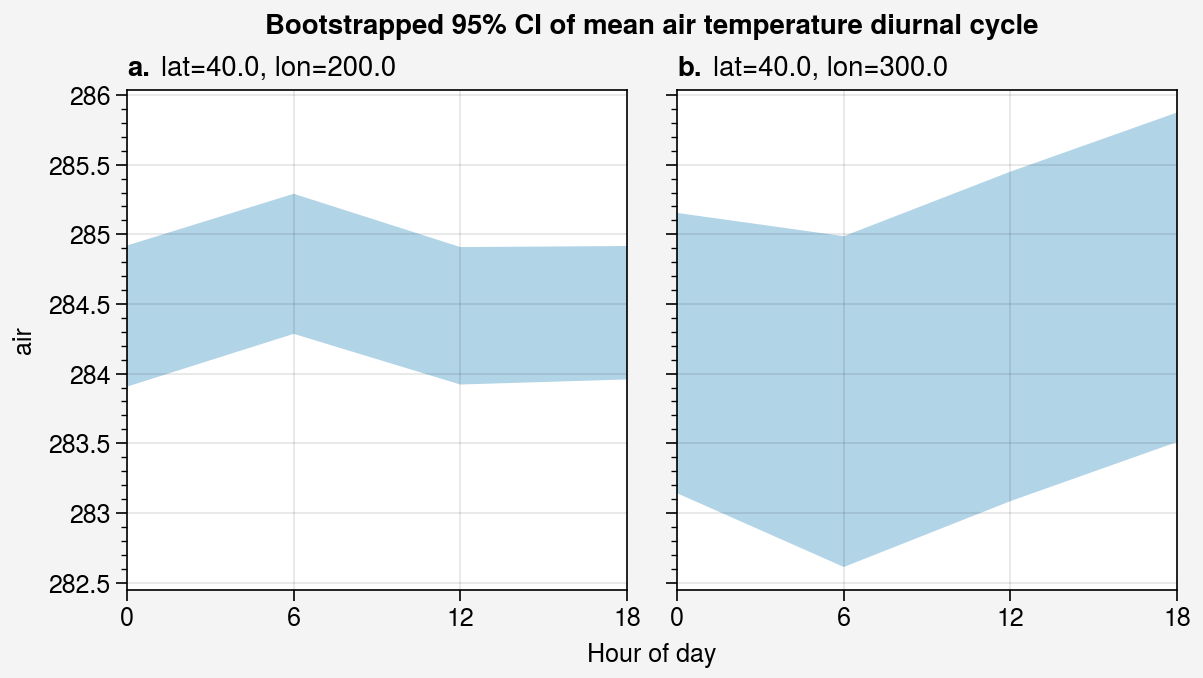

In [8]:
sample_gridpoint1 = grouped_ci_of_mean.sel(lat=40, lon=200)
sample_gridpoint2 = grouped_ci_of_mean.sel(lat=40, lon=300)

# error plot providing the 95% confidence interval
fig, axes = uplt.subplots(
    ncols=2, sharey=4
)  # sharey=4: highest level of sharing y-axis

for i, sample_gridpoint in enumerate([sample_gridpoint1, sample_gridpoint2]):
    ax = axes[i]
    lower = sample_gridpoint.air.sel(quantile=0.025)
    upper = sample_gridpoint.air.sel(quantile=0.975)

    ax.fill_between(lower.hour, lower, upper, alpha=0.3)
    ax.format(
        ltitle=f"lat={sample_gridpoint.lat.values}, lon={sample_gridpoint.lon.values}",
        xlabel="Hour of day",
        xlocator=6,
        xtickminor=False
    )

fig.format(
    abc="a.", suptitle="Bootstrapped 95% CI of mean air temperature diurnal cycle"
)